In [129]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import VotingRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import model_selection
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.neural_network import MLPRegressor
import time
%matplotlib inline

In [41]:
X, y = load_diabetes(return_X_y=True, as_frame=True)
X['target'] = y
display(X.head())
display(X.shape)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


(442, 11)

Визначемо корельованість даних, щоб з'ясувати які алгоритми регресії більше підходять нашим даним.

In [42]:
CorrKoef = X.corr()
CorrKoef

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
age,1.000000,0.173737,0.185085,0.335428,0.260061,0.219243,-0.075181,0.203841,0.270774,0.301731,0.187889
sex,0.173737,1.000000,0.088161,0.241010,0.035277,0.142637,-0.379090,0.332115,0.149916,0.208133,0.043062
bmi,0.185085,0.088161,1.000000,0.395411,0.249777,0.261170,-0.366811,0.413807,0.446157,0.388680,0.586450
bp,0.335428,0.241010,0.395411,1.000000,0.242464,0.185548,-0.178762,0.257650,0.393480,0.390430,0.441482
s1,0.260061,0.035277,0.249777,0.242464,1.000000,0.896663,0.051519,0.542207,0.515503,0.325717,0.212022
s2,0.219243,0.142637,0.261170,0.185548,0.896663,1.000000,-0.196455,0.659817,0.318357,0.290600,0.174054
s3,-0.075181,-0.379090,-0.366811,-0.178762,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697,-0.394789
s4,0.203841,0.332115,0.413807,0.257650,0.542207,0.659817,-0.738493,1.000000,0.617859,0.417212,0.430453
s5,0.270774,0.149916,0.446157,0.393480,0.515503,0.318357,-0.398577,0.617859,1.000000,0.464669,0.565883
s6,0.301731,0.208133,0.388680,0.390430,0.325717,0.290600,-0.273697,0.417212,0.464669,1.000000,0.382483


In [43]:
CorField = []
for i in CorrKoef:
    for j in CorrKoef.index[CorrKoef[i] > 0.7]:
        if i > j or i < j and j not in CorField and i not in CorField:
            CorField.append(j)
            print("%s-->%s: r^2=%f" % (i,j, CorrKoef[i][CorrKoef.index==j].values[0]))

s1-->s2: r^2=0.896663
s2-->s1: r^2=0.896663


Отже, бачимо, що загалом  дані не є корельованими, тому алгоритми лассо та гребеневу регресію виокристовувати не будемо. Можна було б видалити ознаки, що не корелюють с таргетом, але спробуємо використати алгоритм зі зменшенням розмірності. 

# Початковi 2D-данi представити графiчно.

In [44]:
X, y = load_diabetes(return_X_y=True)

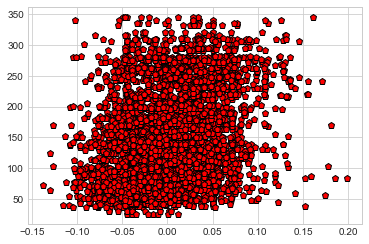

In [45]:
plt.plot(X, y, 'p', color='black', markersize=7,markerfacecolor='red')

# Розбити данi на навчальний, перевiрочний та тестовий набори. 
Перевiрочний набiр використати для налаштування гiперпараметрiв. Тестовий набiр використати для остаточної оцiнки якостi моделей.

In [46]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

In [47]:
X_train.shape


(353, 10)

# Побудувати ансамблі моделей VotingRegressor. 
Розглянути рiзнi значення weights.

In [48]:
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = LinearRegression()
reg4 = AdaBoostRegressor()
reg5 = MLPRegressor()
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3), ('ad', reg4), ('MLP', reg5)], n_jobs=-1).fit(X_train, y_train)

In [49]:
y_predict = ereg.predict(X_test)
y2 = ereg.predict(X_train)

Використаємо метрику RMSE. Метрика, що повідомляє нам квадратний корінь із середньої квадратичної різниці між прогнозованими значеннями та фактичними значеннями у наборі даних. Чим нижче RMSE, тим краще модель відповідає набору даних.

In [50]:
print(mean_squared_error(y_test, y_predict, squared=False))
print(mean_squared_error(y_train, y2, squared=False))

60.35690468313475
49.44602651471276


## Бачимо погані результати, тож за допомогою GridSearch підберемо гіперпараметри для кожної моделі (складових ансамбля), та розглянемо різні значення weights.

На жаль, меня не вдалось підібрати гіперпараметри кожної моделі за допомогою решітчастого пошуку, тож я підібрала їх самостійно.

In [142]:
tik = time.time()
reg1 = GradientBoostingRegressor(loss='squared_error', learning_rate = 0.5, subsample = 1, criterion='friedman_mse', min_samples_leaf = 2, min_samples_split = 4).fit(X_train, y_train)
tak = time.time()
print('Витрачений час у секундах на метод градієнтного бустингу: ',tak-tik)
a = reg1.predict(X_train)
print(mean_squared_error(y_train, a, squared=False))
print('MAE: 'f'{mean_absolute_error(y_train, a):.2f}',
      'MAPE: 'f'{mean_absolute_percentage_error(y_train, a):.3f}')
print('Значення дисперсії: ', explained_variance_score(y_train, a))

Витрачений час у секундах на метод градієнтного бустингу:  0.23451638221740723
6.872696406412878
MAE: 4.97 MAPE: 0.045
Значення дисперсії:  0.9918974918855163


Text(0.5, 0, 'training samples')

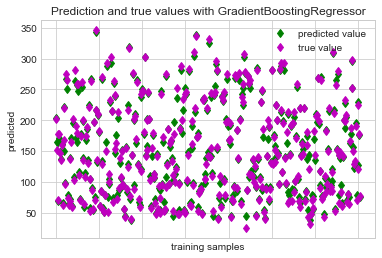

In [99]:
plt.figure()
plt.plot(a, 'gd', label='predicted value')
plt.plot(y_train, 'md', label='true value')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.legend(loc="best")
plt.title('Prediction and true values with GradientBoostingRegressor')
plt.ylabel('predicted')
plt.xlabel('training samples')

In [67]:
tik=time.time()
reg2 = RandomForestRegressor(criterion='poisson', max_depth = 15, min_samples_split=2, min_samples_leaf=1, max_features = 'sqrt').fit(X_train, y_train)
tak = time.time()
print('Витрачений час у секундах на метод випадкових лісів: ',tak-tik)
b = reg2.predict(X_train)
print(mean_squared_error(y_train, b, squared=False))
print('MAE: 'f'{mean_absolute_error(y_train, b):.2f}\n',
      'MAPE: 'f'{mean_absolute_percentage_error(y_train, b):.3f}')
print('Значення дисперсії: ', explained_variance_score(y_train, b))


Витрачений час у секундах на метод випадкових лісів:  0.14850902557373047
21.54675989170672
17.38 0.154


Text(0.5, 0, 'training samples')

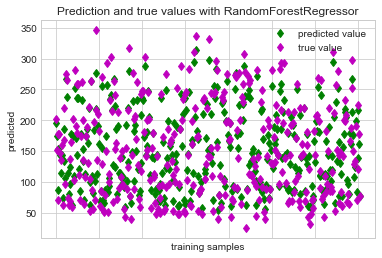

In [100]:
plt.figure()
plt.plot(b, 'gd', label='predicted value')
plt.plot(y_train, 'md', label='true value')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.legend(loc="best")
plt.title('Prediction and true values with RandomForestRegressor')
plt.ylabel('predicted')
plt.xlabel('training samples')

In [141]:
tik=time.time()
reg3 = LinearRegression(n_jobs = -1, positive = False).fit(X_train,y_train)
tak = time.time()
print('Витрачений час у секундах на метод лінійної регресії: ',tak-tik)
c = reg3.predict(X_test)
print(mean_squared_error(y_test, c, squared=False))
print('MAE: 'f'{mean_absolute_error(y_test, c):.2f}\n',
      'MAPE: 'f'{mean_absolute_percentage_error(y_test, c):.3f}')
print('Значення дисперсії: ', explained_variance_score(y_test, c))

Витрачений час у секундах на метод лінійної регресії:  0.0057485103607177734
54.891469875468715
MAE: 45.10
 MAPE: 0.398
Значення дисперсії:  0.5247879736619935


Text(0.5, 0, 'training samples')

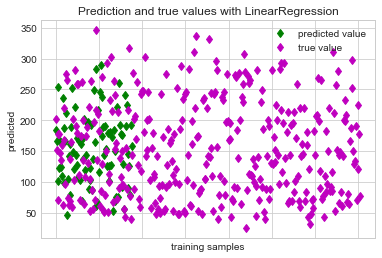

In [101]:
plt.figure()
plt.plot(c, 'gd', label='predicted value')
plt.plot(y_train, 'md', label='true value')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.legend(loc="best")
plt.title('Prediction and true values with LinearRegression')
plt.ylabel('predicted')
plt.xlabel('training samples')

In [139]:
tik=time.time()
reg4 = AdaBoostRegressor(n_estimators = 400, learning_rate = 0.2, loss = 'square').fit(X_train, y_train)
tak = time.time()
print('Витрачений час у секундах на метод Адабустингу: ',tak-tik)
d = reg4.predict(X_train)
print(reg4.score(X_train,y_train))
print(mean_squared_error(y_train, d, squared=False))
print('MAE: 'f'{mean_absolute_error(y_train, d):.2f}\n',
     'MAPE: ' f'{mean_absolute_percentage_error(y_train, d):.3f}')
print('Значення дисперсії: ', explained_variance_score(y_train, d))

Витрачений час у секундах на метод Адабустингу:  1.7039318084716797
0.6313778892373054
46.356230465566824
MAE: 40.71
 MAPE: 0.390
Значення дисперсії:  0.6327803159960874


Text(0.5, 0, 'training samples')

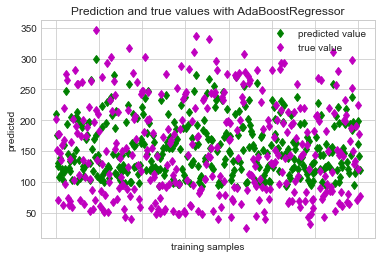

In [103]:
plt.figure()
plt.plot(d, 'gd', label='predicted value')
plt.plot(y_train, 'md', label='true value')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.legend(loc="best")
plt.title('Prediction and true values with AdaBoostRegressor')
plt.ylabel('predicted')
plt.xlabel('training samples')

In [136]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)
tik=time.time()
reg5 = MLPRegressor(activation = 'tanh', solver = 'sgd', alpha = 0.000001, max_iter=60000).fit(X_train, y_train)
tak = time.time()
print('Витрачений час у секундах на метод MLPRegressor: ',tak-tik)
e = reg5.predict(X_train)
print(reg5.score(X_train,y_train))
print(mean_squared_error(y_train, e, squared=False))
print('MAE: 'f'{mean_absolute_error(y_train, e):.2f}\n',
      'MAPE: 'f'{mean_absolute_percentage_error(y_train, e):.3f}')
print('Значення дисперсії: ', explained_variance_score(y_train, e))

Витрачений час у секундах на метод MLPRegressor:  6.063045978546143
0.8384075821085452
30.692192414092965
MAE: 24.37
 MAPE: 0.208
Значення дисперсії:  0.8415661007648112


Text(0.5, 0, 'training samples')

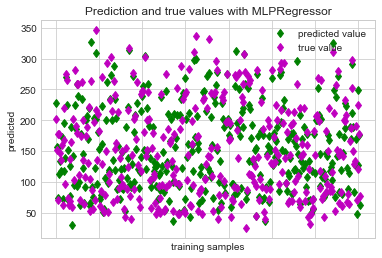

In [106]:
plt.figure()
plt.plot(e, 'gd', label='predicted value')
plt.plot(y_train, 'md', label='true value')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.legend(loc="best")
plt.title('Prediction and true values with MLPRegressor')
plt.ylabel('predicted')
plt.xlabel('training samples')

In [107]:
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3), ('ad', reg4), ('MLP', reg5)], n_jobs=-1).fit(X_train, y_train)

In [108]:
params = {'weights':[(1, 2, 1, 1,1), (3,2,1, 2,1), (2,3,1, 2,1), (2,2,1,1,1), (1,2,1,2,2),(2,1,1,1,1)]}

In [109]:
grid = GridSearchCV(ereg, params)
grid.fit(X_train, y_train)
grid.best_params_

{'weights': (2, 2, 1, 1, 1)}

In [124]:
tik=time.time()
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3), ('ad', reg4), ('MLP', reg5)],weights = (4,1,1,1,1), n_jobs=-1).fit(X_train, y_train)
tak = time.time()
print('Витрачений час у секундах для ансамблю: ',tak-tik)

Витрачений час у секундах для ансамблю:  1.9084315299987793


In [125]:
y_predict = ereg.predict(X_test)

In [137]:
print('MSE: ', mean_squared_error(y_test, y_predict, squared=False))
print(ereg.score(X_test, y_test))

MSE:  58.09065981855518
0.46660630211646525


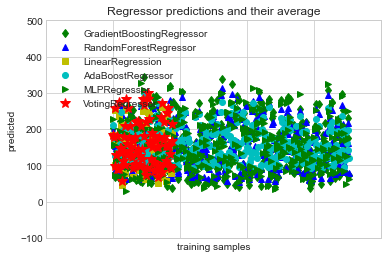

In [127]:
plt.figure()
plt.plot(a, 'gd', label='GradientBoostingRegressor')
plt.plot(b, 'b^', label='RandomForestRegressor')
plt.plot(c, 'ys', label='LinearRegression')
plt.plot(d, 'co', label='AdaBoostRegressor')
plt.plot(e, 'g>', label='MLPRegressor')
plt.plot(y_predict, 'r*', ms=10, label='VotingRegressor')

plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Regressor predictions and their average')
plt.xlim([-100,400])
plt.ylim([-100,500])
plt.show()

Text(0.5, 0, 'training samples')

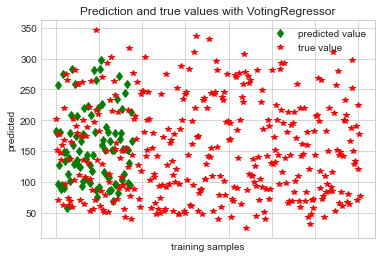

In [128]:
plt.figure()
plt.plot(y_predict, 'gd', label='predicted value')
plt.plot(y_train, 'r*', label='true value')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.legend(loc="best")
plt.title('Prediction and true values with VotingRegressor')
plt.ylabel('predicted')
plt.xlabel('training samples')

In [131]:
explained_variance_score(y_test, y_predict)

0.4730520551778886

# Висновок

  Окремі моделі навчаються набагато швидше ніж ансамбль, максимальний час навчання окремої моделі 0.2 секунди (GradientBoostingRegressor), а навчання ансамблю займає 2 секунди, тобто в 10 разів швидше навчається окрема модель. 
  Найкращі показники метрик, тобто дисперсії, MAE та MAPE, отримала на моделі GradientBoostingRegressor. Тож, на заданих даних краще працює індивідуальна модель, це можна побачити на графіку, проаналізувавши метрики та час.
  Роль ідивідуальної моделі у мене грає все ж таки ансамбль GradientBoostingRegressor. По завданню треба перевірити роботу VotingRegressor, він спрацював досить погано, бо для регресії береться середнє зачення моделей, а всі моделі, що беруть участь у голосуванні, крім GradientBoostingRegressor, мають незадовільні результати.